In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def Hamiltonian(B1, B2, J):
    H = []

    J = J / 4
    B1 = B1 / 2
    B2 = B2 / 2

    H.append([B1, ['z', [0]]])
    H.append([B2, ['z', [1]]])

    H.append([J, ['xx', [0, 1]]])

    return H

from qutip import sigmax, sigmay, sigmaz, tensor, qeye, basis, mesolve, expect

sx = sigmax()
sy = sigmay()
sz = sigmaz()


def get_qutip_term(term, number_of_sites):
    # term = [pauli_str, [site1, site2, ...]]
    # number_of_sites = number of sites in the lattice
    operators = [qeye(2) for _ in range(number_of_sites)]
    Paulis_dict = dict(zip(['x', 'y', 'z'], [sx, sy, sz]))

    pauli_str, sites = term
    for site, p in enumerate(pauli_str):
        operators[sites[site]] = Paulis_dict[p]
    return tensor(operators)

def get_qutip_hamiltonian(H, number_of_sites):
    return sum([coeff * get_qutip_term(term, number_of_sites) for coeff, term in H])

In [45]:
J = 0.1
B1 = -1
B2 = -2

H = Hamiltonian(B1, B2, J)
H_qutip = get_qutip_hamiltonian(H, 2)

H_qutip.groundstate()[0]

-1.475

In [46]:
from Modules.sympy.classes import *
from Modules.sympy.utils import *

In [53]:
def Hamiltonian_PySW(B1, B2, J):

    spin_basis = [RDBasis(f"\\sigma^{{{i}}}", f'spin{i}', dim = 2) for i in range(2)]

    J = J / 4
    B1 = B1 / 2
    B2 = B2 / 2

    S0x, S0y, S0z = spin_basis[0]._basis[1:]
    S1x, S1y, S1z = spin_basis[1]._basis[1:]

    H0 = B1 * S0z + B2 * S1z
    V = J * S0x * S1x

    return H0, V, spin_basis

In [61]:
from Modules.sympy.truncated.solver import solver as solver_truncated
from Modules.sympy.truncated.solver import get_ansatz

energies_block = []
energies_full = []
max_order = 10

N = 2

B1s = RDsymbol('B1', order=0) # 1
B2s = RDsymbol('B2', order=0) # 2
Js = RDsymbol('J', order=1) # -1

H0, V, spin_basis = Hamiltonian_PySW(B1s, B2s, Js)
composite_basis = RDCompositeBasis(spin_basis)
subspaces = [[spin.subspace, 2] for spin in spin_basis]

J = 0.1
B1 = -1
B2 = -2

H = Hamiltonian(B1, B2, J)
H_qutip = get_qutip_hamiltonian(H, N)

Energies = np.sort(np.linalg.eigvals(H_qutip.full()))

H_pySw = H0 + V

for order in range(1, max_order+1):
    sol_block = solver_truncated(H_pySw, subspaces, order=order, full_diagonal=False)
    energies_sol = sol_block[0].subs({Js: J, B1s : B1, B2s : B2})
    energies_block.append(np.sort(np.array(list(energies_sol.diagonal()))))

    sol_full = solver_truncated(H_pySw, subspaces, order=order, full_diagonal=True)
    energies_sol = sol_full[0].subs({Js: J, B1s : B1, B2s : B2})
    energies_full.append(np.sort(np.array(list(energies_sol.diagonal()))))

100%|██████████| 2046/2046 [00:20<00:00, 100.97it/s]


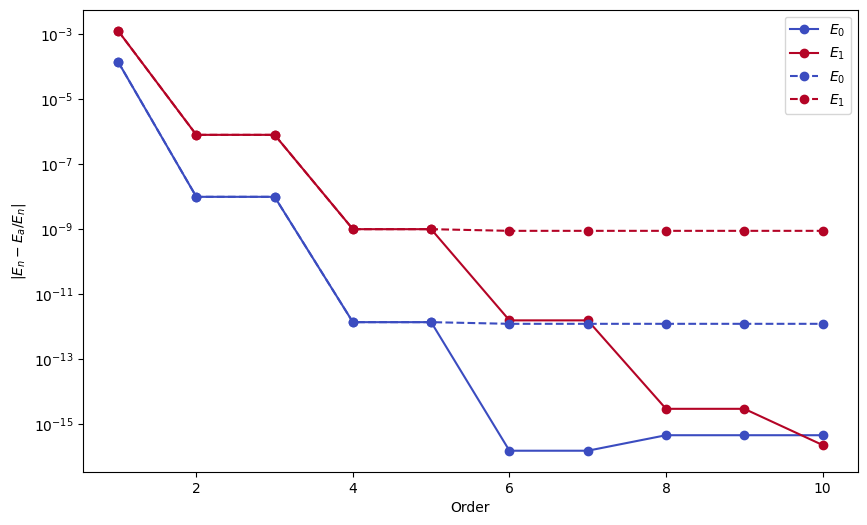

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

energies_order = np.zeros((len(energies_full[0]), max_order), np.float64)

n_cut = 2**N - 2


for order, order_energies in enumerate(energies_full):
    result = np.abs((Energies - order_energies) / Energies)
    energies_order[:, order] = result

cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, len(energies_order)-n_cut)]

color_list = colors

for i, energies in enumerate(energies_order[:-n_cut]):
    ax.plot(np.arange(1, max_order+1), energies, '-o', label = f"$E_{i}$", color=color_list[i])

energies_order = np.zeros((len(energies_full[0]), max_order), np.float64)

for order, order_energies in enumerate(energies_block):
    result = np.abs((Energies - order_energies) / Energies)
    energies_order[:, order] = result

for i, energies in enumerate(energies_order[:-n_cut]):
    ax.plot(np.arange(1, max_order+1), energies, label = f"$E_{i}$", color=color_list[i], linestyle='--', marker='o')

ax.set_yscale("log")
#ax.set_ylim(10**-13, 10**-1)
ax.set_xlabel("Order")
ax.set_ylabel(r"$|E_n - E_a / E_n|$")
ax.legend()


#fig.savefig("Images/Rabi_Full.svg", bbox_inches='tight')
#fig.savefig("Images/Rabi_Full.pdf", bbox_inches='tight')

In [63]:
H0_mat = get_matrix(H0, subspaces)
V_mat = get_matrix(V, subspaces)

S1 = sol_full[1]['1']

In [57]:
Energies

array([-1.50020832+0.j, -0.50062461+0.j,  0.50062461+0.j,  1.50020832+0.j])

In [58]:
sol_full[0].subs({Js: J, B1s : B1, B2s : B2})

Matrix([
[-1.50020831886775,                 0,                  0,                0],
[                0, 0.500624609863281,                  0,                0],
[                0,                 0, -0.500624609863281,                0],
[                0,                 0,                  0, 1.50020831886775]])

In [64]:
from Modules.sympy.untruncated.solver import solver as solver_untruncated
from Modules.sympy.untruncated.solver import get_ansatz


energies_block = []
energies_full = []
max_order = 10

N = 2

B1s = RDsymbol('B1', order=0) # 1
B2s = RDsymbol('B2', order=0) # 2
Js = RDsymbol('J', order=1) # -1

H0, V, spin_basis = Hamiltonian_PySW(B1s, B2s, Js)
composite_basis = RDCompositeBasis(spin_basis)
subspaces = [[spin.subspace, 2] for spin in spin_basis]

J = 0.1
B1 = -1
B2 = -2

H = Hamiltonian(B1, B2, J)
H_qutip = get_qutip_hamiltonian(H, N)

Energies = np.sort(np.linalg.eigvals(H_qutip.full()))

H_pySw = H0 + V

for order in range(1, max_order+1):
    sol_block = solver_untruncated(H_pySw, composite_basis, order=order, full_diagonal=False)
    energies_sol = get_matrix(sol_block[0].subs({Js: J, B1s : B1, B2s : B2}), subspaces)
    energies_block.append(np.sort(np.array(list(energies_sol.diagonal()))))

    sol_full = solver_untruncated(H_pySw, composite_basis, order=order, full_diagonal=True)
    energies_sol = get_matrix(sol_full[0].subs({Js: J, B1s : B1, B2s : B2}), subspaces)
    energies_full.append(np.sort(np.array(list(energies_sol.diagonal()))))

100%|██████████| 2046/2046 [02:10<00:00, 15.72it/s] 


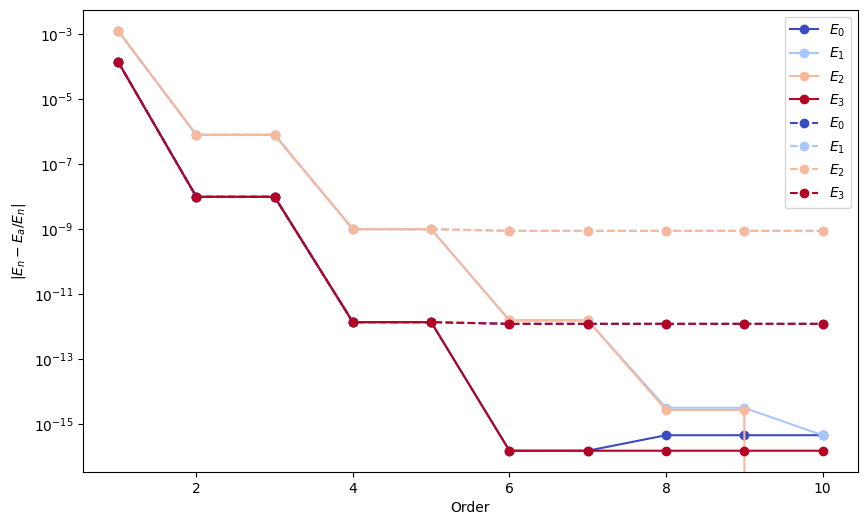

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

energies_order = np.zeros((len(energies_full[0]), max_order), np.float64)

n_cut = 0*2**N


for order, order_energies in enumerate(energies_full):
    result = np.abs((Energies - order_energies) / Energies)
    energies_order[:, order] = result

cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, len(energies_order)-n_cut)]

color_list = colors

for i, energies in enumerate(energies_order[:]):
    ax.plot(np.arange(1, max_order+1), energies, '-o', label = f"$E_{i}$", color=color_list[i])

energies_order = np.zeros((len(energies_full[0]), max_order), np.float64)

for order, order_energies in enumerate(energies_block):
    result = np.abs((Energies - order_energies) / Energies)
    energies_order[:, order] = result

for i, energies in enumerate(energies_order[:]):
    ax.plot(np.arange(1, max_order+1), energies, label = f"$E_{i}$", color=color_list[i], linestyle='--', marker='o')

ax.set_yscale("log")
#ax.set_ylim(10**-13, 10**-1)
ax.set_xlabel("Order")
ax.set_ylabel(r"$|E_n - E_a / E_n|$")
ax.legend()


In [79]:
(Energies - energies_full[-1])/Energies

array([4.44027543639969e-16, 4.43535137008164e-16, 0,
       1.48009181213323e-16], dtype=object)